## 8장 딥러닝
딥러닝은 층을 깊게 한 심층 신경망입니다. 심층 신경망은 지금까지 설명한 신경망을 바탕으로 뒷단에 층을 추가하기만 하면 만들 수 있지만, 커다란 문제가 몇 개 있습니다. 이번 장에서는 딥러닝의 특징과 과제, 그리고 가능성을 살펴봅니다. 또 오늘날의 첨단 딥러닝에 대한 설명도 준비했습니다.

 Copyrights
1. https://github.com/WegraLee/deep-learning-from-scratch

### Customized by Gil-Jin Jang, May 6, 2021

## 파일 설명
| 파일명 | 파일 용도 | 관련 절 | 페이지 |
|:--   |:--      |:--    |:--      |
| awesome_net.py | 빈 파일입니다. 여기에 여러분만의 멋진 신경망을 구현해보세요! |  |  |
| deep_convnet.py | [그림 8-1]의 깊은 신경망을 구현한 소스입니다. | 8.1.1 더 깊은 신경망으로 | 262 |
| train_deepnet.py | deep_convnet.py의 신경망을 학습시킵니다. 몇 시간은 걸리기 때문에 다른 코드에서는 미리 학습된 가중치인 deep_convnet_params.pkl을 읽어서 사용합니다. | 8.1.1 더 깊은 신경망으로 | 262 |
| deep_convnet_params.pkl | deep_convnet.py용 학습된 가중치입니다. |  |  |
| misclassified_mnist.py | 이번 장에서 구현한 신경망이 인식에 실패한 손글씨 이미지들을 화면에 보여줍니다. | 8.1.1 더 깊은 신경망으로 | 263 |
| half_float_network.py | 수치 정밀도를 반정밀도(16비트)로 낮춰 계산하여 배정밀도(64비트)일 때와 정확도를 비교해본다. | 8.3.4 연산 정밀도와 비트 줄이기 | 278 |


## 목차
```
8.1 더 깊게 
__8.1.1 더 깊은 네트워크로 
__8.1.2 정확도를 더 높이려면 
__8.1.3 깊게 하는 이유 
8.2 딥러닝의 초기 역사 
__8.2.1 이미지넷 
__8.2.2 VGG 
__8.2.3 GoogLeNet 
__8.2.4 ResNet 
8.3 더 빠르게(딥러닝 고속화) 
__8.3.1 풀어야 할 숙제 
__8.3.2 GPU를 활용한 고속화 
__8.3.3 분산 학습 
__8.3.4 연산 정밀도와 비트 줄이기 
8.4 딥러닝의 활용 
__8.4.1 사물 검출 
__8.4.2 분할 
__8.4.3 사진 캡션 생성 
8.5 딥러닝의 미래 
__8.5.1 이미지 스타일(화풍) 변환 
__8.5.2 이미지 생성 
__8.5.3 자율 주행 
__8.5.4 Deep Q-Network(강화학습) 
```

## 8.1 더 깊게 
### 8.1.1 더 깊은 네트워크로 

<img src="images/fig 8-1.png">손글씨 심층 CNN</img>

In [1]:
# coding: utf-8
# deep_conv_net.py
# [그림 8-1]의 깊은 신경망을 구현한 소스입니다.

import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *


class DeepConvNet:
    """정확도 99% 이상의 고정밀 합성곱 신경망

    네트워크 구성은 아래와 같음
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        # 가중치 초기화===========
        # 각 층의 뉴런 하나당 앞 층의 몇 개 뉴런과 연결되는가（TODO: 자동 계산되게 바꿀 것）
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # ReLU를 사용할 때의 권장 초깃값
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # 계층 생성===========
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5))
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5))
        
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]


In [2]:
# coding: utf-8
# train_deepnet.py
# deep_convnet_params.pkl 
# deep_convnet.py의 신경망을 학습시킵니다. 몇 시간은 걸리기 때문에 다른 코드에서는 미리 학습된 가중치인 deep_convnet_params.pkl을 읽어서 사용합니다. | 8.1.1 더 깊은 신경망으로 | 262 |

import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from deep_convnet import DeepConvNet
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)


# # 시간이 오래 걸릴 경우 데이터를 줄인다.
# x_train, t_train = x_train[:5000], t_train[:5000]
# x_test, t_test = x_test[:1000], t_test[:1000]


network = DeepConvNet()  
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=20, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보관
network.save_params("deep_convnet_params.pkl")
print("Saved Network Parameters!")

train loss:2.289029940044845
=== epoch:1, train acc:0.162, test acc:0.158 ===
train loss:2.2905278730168135
train loss:2.2697637703647144
train loss:2.202111507012904
train loss:2.169426752084157
train loss:2.2401500338456852
train loss:2.2423987255937803
train loss:2.221591512722507
train loss:2.1937016750128873
train loss:2.1665296650656303
train loss:2.1569270661837354
train loss:2.1819389759303602
train loss:2.169752832746863
train loss:2.0885505433366576
train loss:2.0909466101360636
train loss:1.9127828215279215
train loss:2.179166652144955
train loss:2.0699513299591095
train loss:2.080603146155029
train loss:2.10419311881949
train loss:2.126822064617728
train loss:2.1058193019547873
train loss:2.177515882880178
train loss:1.9407114036761226
train loss:1.9971538532772184
train loss:1.9128284140666718
train loss:2.0766246326418187
train loss:1.9564347255081886
train loss:1.9644357556786614
train loss:2.0329229383475793
train loss:1.7404756250931306
train loss:1.7109828073174944
tr

KeyboardInterrupt: 

calculating test accuracy ... 
test accuracy:0.867
======= misclassified result =======
{view index: (label, inference), ...}
{1: (4, 6), 2: (7, 5), 3: (4, 6), 4: (5, 7), 5: (9, 5), 6: (4, 6), 7: (6, 4), 8: (3, 4), 9: (6, 0), 10: (3, 6), 11: (7, 9), 12: (6, 4), 13: (2, 4), 14: (2, 6), 15: (4, 2), 16: (4, 6), 17: (8, 6), 18: (9, 7), 19: (2, 4), 20: (6, 2)}


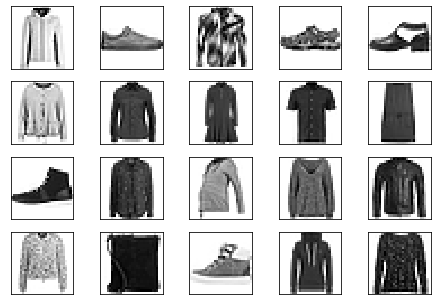

In [6]:
# misclassified_mnist.py 
# 이번 장에서 구현한 신경망이 인식에 실패한 손글씨 이미지들을 화면에 보여줍니다.
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from deep_convnet import DeepConvNet
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("deep_convnet_params.pkl")

print("calculating test accuracy ... ")
sampled = 1000
x_test = x_test[:sampled]
t_test = t_test[:sampled]

classified_ids = []

acc = 0.0
batch_size = 100

for i in range(int(x_test.shape[0] / batch_size)):
    tx = x_test[i*batch_size:(i+1)*batch_size]
    tt = t_test[i*batch_size:(i+1)*batch_size]
    y = network.predict(tx, train_flg=False)
    y = np.argmax(y, axis=1)
    classified_ids.append(y)
    acc += np.sum(y == tt)
    
acc = acc / x_test.shape[0]
print("test accuracy:" + str(acc))

classified_ids = np.array(classified_ids)
classified_ids = classified_ids.flatten()
 
max_view = 20
current_view = 1

fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

mis_pairs = {}
for i, val in enumerate(classified_ids == t_test):
    if not val:
        ax = fig.add_subplot(4, 5, current_view, xticks=[], yticks=[])
        ax.imshow(x_test[i].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
        mis_pairs[current_view] = (t_test[i], classified_ids[i])
            
        current_view += 1
        if current_view > max_view:
            break

print("======= misclassified result =======")
print("{view index: (label, inference), ...}")
print(mis_pairs)

plt.show()

<img src="images/fig 8-2.png">인식하지 못한(misclassified) 이미지들</img>

### 8.1.2 정확도를 더 높이려면 

<img src="images/fig 8-3.png">MNIST rankings</img>

<img src="images/fig 8-4.png">Data augmentation</img>

### 8.1.3 깊게 하는 이유 

<img src="images/fig 8-5.png">5x5 convolution</img>

<img src="images/fig 8-6.png">Multiple 3x3 convoltions</img>

## 8.2 딥러닝의 초기 역사 
### 8.2.1 이미지넷 
<img src="images/fig 8-7.png">ImageNet samples</img>

<img src="images/fig 8-8.png">ILSVRC rankings</img>

### 8.2.2 VGG 
<img src="images/fig 8-9.png">VGGNet</img>

### 8.2.3 GoogLeNet 
<img src="images/fig 8-10.png">GoogLeNet</img>

<img src="images/fig 8-11.png">Inception module in GoogLeNet</img>

### 8.2.4 ResNet 
<img src="images/fig 8-12.png">ResNet module</img>

<img src="images/fig 8-13.png">RegNet</img>

## 8.3 더 빠르게(딥러닝 고속화) 
### 8.3.1 풀어야 할 숙제 
<img src="images/fig 8-14.png">AlextNet forward 처리시 각 층의 시간비율</img>

### 8.3.2 GPU를 활용한 고속화 
<img src="images/fig 8-15.png">AlexNet 시간비교</img>

### 8.3.3 분산 학습 
<img src="images/fig 8-16.png">완전연결 계층(Affine 계층)으로 이루어진 네트워크의 예</img>

### 8.3.4 연산 정밀도와 비트 줄이기 

In [7]:
# half_float_network.py 
# 수치 정밀도를 반정밀도(16비트)로 낮춰 계산하여 배정밀도(64비트)일 때와 정확도를 비교해본다.
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from deep_convnet import DeepConvNet
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("deep_convnet_params.pkl")

sampled = 10000 # 고속화를 위한 표본추출
x_test = x_test[:sampled]
t_test = t_test[:sampled]

print("caluculate accuracy (float64) ... ")
print(network.accuracy(x_test, t_test))

# float16(반정밀도)로 형변환
x_test = x_test.astype(np.float16)
for param in network.params.values():
    param[...] = param.astype(np.float16)

print("caluculate accuracy (float16) ... ")
print(network.accuracy(x_test, t_test)) 

caluculate accuracy (float64) ... 
0.851
caluculate accuracy (float16) ... 
0.851


## 8.4 딥러닝의 활용 
### 8.4.1 사물 검출 
<img src="images/fig 8-17.png">사물 검출의 예시</img>

<img src="images/fig 8-18.png">R-CNN</img>

### 8.4.2 분할 
<img src="images/fig 8-19.png">Segmentation</img>

<img src="images/fig 8-20.png">FCN</img>

### 8.4.3 사진 캡션 생성 
<img src="images/fig 8-21.png">Image Captioning</img>

<img src="images/fig 8-22.png">NIC</img>

## 8.5 딥러닝의 미래 
### 8.5.1 이미지 스타일(화풍) 변환 
<img src="images/fig 8-23.png">A Neural Algorithm of Artistic Style</img>

### 8.5.2 이미지 생성 
<img src="images/fig 8-24.png">DCGAN</img>

### 8.5.3 자율 주행 
<img src="images/fig 8-25.png">딥러닝을 활용한 이미지 분할의 예</img>

### 8.5.4 Deep Q-Network(강화학습) 
<img src="images/fig 8-26.png">강화학습의 기본 틀</img>

<img src="images/fig 8-27.png">Deep Q-Network</img>

## 이번 장에서 배운 내용
* 수많은 문제에서 신경망을 더 깊게 하여 성능을 개선할 수 있다.
* 이미지 인식 기술 대회인 ILSVRC에서는 최근 딥러닝 기반 기법이 상위권을 독점하고 있으며, 그 깊이도 더 깊어지는 추세다.
* 유명한 신경망으로는 VGG, GoogLeNet, ResNet이 있다.
* GPU와 분산 학습, 비트 정밀도 감소 등으로 딥러닝을 고속화할 수 있다.
* 딥러닝(신경망)은 사물 인식뿐 아니라 사물 검출과 분할에도 이용할 수 있다.
* 딥러닝의 응용 분야로는 사진의 캡션 생성, 이미지 생성, 강화학습 등이 있다. 최근에는 자율 주행에도 딥러닝을 접목하고 있어 기대된다.

## 8.1 더 깊게 
### 8.1.1 더 깊은 네트워크로 

<img src="images/fig 8-1.png">손글씨 심층 CNN</img>

<img src="images/fig 8-2.png">인식하지 못한(misclassified) 이미지들</img>

### 8.1.2 정확도를 더 높이려면 

<img src="images/fig 8-3.png">MNIST rankings</img>

<img src="images/fig 8-4.png">Data augmentation</img>

### 8.1.3 깊게 하는 이유 

<img src="images/fig 8-5.png">5x5 convolution</img>

<img src="images/fig 8-6.png">Multiple 3x3 convoltions</img>

## 8.2 딥러닝의 초기 역사 
### 8.2.1 이미지넷 
<img src="images/fig 8-7.png">ImageNet samples</img>

<img src="images/fig 8-8.png">ILSVRC rankings</img>

### 8.2.2 VGG 
<img src="images/fig 8-9.png">VGGNet</img>

### 8.2.3 GoogLeNet 
<img src="images/fig 8-10.png">GoogLeNet</img>

<img src="images/fig 8-11.png">Inception module in GoogLeNet</img>

### 8.2.4 ResNet 
<img src="images/fig 8-12.png">ResNet module</img>

<img src="images/fig 8-13.png">RegNet</img>

## 8.3 더 빠르게(딥러닝 고속화) 
### 8.3.1 풀어야 할 숙제 
<img src="images/fig 8-14.png">AlextNet forward 처리시 각 층의 시간비율</img>

### 8.3.2 GPU를 활용한 고속화 
<img src="images/fig 8-15.png">AlexNet 시간비교</img>

### 8.3.3 분산 학습 
<img src="images/fig 8-16.png">완전연결 계층(Affine 계층)으로 이루어진 네트워크의 예</img>

### 8.3.4 연산 정밀도와 비트 줄이기 

## 8.4 딥러닝의 활용 
### 8.4.1 사물 검출 
<img src="images/fig 8-17.png">사물 검출의 예시</img>

<img src="images/fig 8-18.png">R-CNN</img>

### 8.4.2 분할 
<img src="images/fig 8-19.png">Segmentation</img>

<img src="images/fig 8-20.png">FCN</img>

### 8.4.3 사진 캡션 생성 
<img src="images/fig 8-21.png">Image Captioning</img>

<img src="images/fig 8-22.png">NIC</img>

## 8.5 딥러닝의 미래 
### 8.5.1 이미지 스타일(화풍) 변환 
<img src="images/fig 8-23.png">A Neural Algorithm of Artistic Style</img>

### 8.5.2 이미지 생성 
<img src="images/fig 8-24.png">DCGAN</img>

### 8.5.3 자율 주행 
<img src="images/fig 8-25.png">딥러닝을 활용한 이미지 분할의 예</img>

### 8.5.4 Deep Q-Network(강화학습) 
<img src="images/fig 8-26.png">강화학습의 기본 틀</img>

<img src="images/fig 8-27.png">Deep Q-Network</img>